In [197]:
import re
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from os.path import exists

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
import spacy
import contextualSpellCheck
import textstat

from keras import models
from keras import layers
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS

In [164]:
# Arbitrary Functions
def save_model(model, name):
    with open(f'Models/{name}.pkl', 'wb') as fid:
        pickle.dump(model, fid)  
        
def load_model(name):
    with open(f'Models/{name}.pkl', 'rb') as fid:
        model = pickle.load(fid)
    return model

In [132]:
data = pd.read_csv('Data/data.csv')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [133]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_elements(input_text):
    text = re.sub(r'@\w+', '', input_text) # Removes tweet mentiones
    text = re.sub(r"\S*https?:\S*", "", text) # Removes URL's
    return text
       
data['Sentence'] = data['Sentence'].apply(remove_stopwords).apply(remove_elements)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology leverage Benefon '...,positive
1,"$ESI lows, $1.50 $2.50 BK real possibility",negative
2,For last quarter 2010 Componenta 's net sales ...,positive
3,According Finnish-Russian Chamber Commerce maj...,neutral
4,The Swedish buyout firm sold remaining 22.4 pe...,neutral


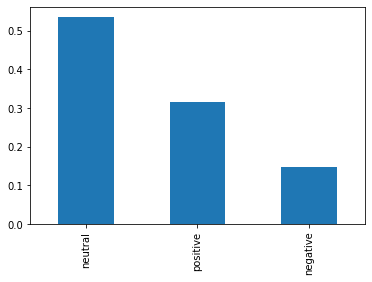

In [134]:
data['Sentiment'].value_counts(normalize=True).plot(kind='bar')
# There is definately a skew here, lets make sure to stratify the train test split to ensure.

In [141]:
data_2 = data.copy()

data_2['Flesch_Score'] = data['Sentence'].map(textstat.flesch_reading_ease)
data_2['Gunning_FOG_Score'] = data['Sentence'].map(textstat.gunning_fog)
data_2.groupby('Sentiment').agg({"Flesch_Score": [np.mean, np.std], "Gunning_FOG_Score" : [np.mean, np.std]})

Flesch_Score            Gunning_FOG_Score          
                  mean        std              mean       std
Sentiment                                                    
negative     60.952023  28.648497          8.198244  5.269671
neutral      38.672476  33.173451         11.992026  6.216698
positive     52.549163  33.511161          9.752970  6.080809

These scores are wild, the standard deviation of the scores are almost the mean. Lets mess around with spelling correction.

In [162]:
test_string = 'Helllo, how are u doig?'
spell_check_nlp = spacy.load('en_core_web_sm')
contextualSpellCheck.add_to_pipe(spell_check_nlp)
test_string_checked = spell_check_nlp(test_string)
print(test_string_checked._.outcome_spellCheck) 

Well, how are u doing?


In [157]:
textBlb = TextBlob(test_string)
str(TextBlob(test_string).correct())

'Hello, how are u doing?'

In [169]:
# This took forever to run
if exists('Models/data_SpellCheck.pkl'):
    data_SpellCheck = load_model('data_SpellCheck')
else: 
    data_SpellCheck['Spacy_SpellCheck'] = data_2['Sentence'].apply(lambda l: spell_check_nlp(l)._.outcome_spellCheck)
    data_SpellCheck['TextBlob_SpellCheck'] = data_2['Sentence'].apply(lambda l: str(TextBlob(l).correct()))

    data_SpellCheck['Spacy_SC_Flesch_Score'] = data_2['Spacy_SpellCheck'].map(textstat.flesch_reading_ease)
    data_SpellCheck['TextBlob_SC_Flesch_Score'] = data_2['TextBlob_SpellCheck'].map(textstat.flesch_reading_ease)
    data_SpellCheck['Spacy_FOG_Score'] = data_2['Spacy_SpellCheck'].map(textstat.gunning_fog)
    data_SpellCheck['TextBlob_FOG_Score'] = data_2['TextBlob_SpellCheck'].map(textstat.gunning_fog)
    save_model(data_SpellCheck,'data_SpellCheck')

In [170]:
data_SpellCheck.groupby('Sentiment').agg({
    "Gunning_FOG_Score": [np.mean, np.std], 
    "Spacy_FOG_Score" : [np.mean, np.std],
    "TextBlob_FOG_Score" : [np.mean, np.std]})

Gunning_FOG_Score           Spacy_FOG_Score            \
                       mean       std            mean       std   
Sentiment                                                         
negative           8.198244  5.269671        6.316174  5.476177   
neutral           11.992026  6.216698        8.042323  7.102083   
positive           9.752970  6.080809        7.012100  6.327693   

          TextBlob_FOG_Score            
                        mean       std  
Sentiment                               
negative            8.123093  5.258748  
neutral            11.848192  6.159813  
positive            9.667505  6.023082

In [171]:
data_SpellCheck.groupby('Sentiment').agg({
    "Flesch_Score": [np.mean, np.std], 
    "Spacy_SC_Flesch_Score" : [np.mean, np.std],
    "TextBlob_SC_Flesch_Score" : [np.mean, np.std]})

Flesch_Score            Spacy_SC_Flesch_Score             \
                  mean        std                  mean        std   
Sentiment                                                            
negative     60.952023  28.648497             91.287860  60.222733   
neutral      38.672476  33.173451             91.001486  78.302357   
positive     52.549163  33.511161             91.257068  68.153700   

          TextBlob_SC_Flesch_Score             
                              mean        std  
Sentiment                                      
negative                 61.542291  28.529795  
neutral                  39.229291  32.953653  
positive                 52.946593  33.564288

In [188]:
# We can do all of this using sklearn count vectorizer, so will give that a try lower down.
def lemma_text(tweet : str, nlp : spacy.lang.en.English, STOP_WORDS : set = STOP_WORDS) -> str:
    doc = nlp(tweet)
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.isalpha() and token.lemma not in STOP_WORDS]
    return ' '.join(lemmas)

lemma_nlp = spacy.load('en_core_web_sm')
data_Lemma = data.copy()

data_Lemma['Sentence_Lemma'] = data_Lemma['Sentence'].apply(lambda l: lemma_text(l, lemma_nlp))
data_Lemma.head()

,Sentence,Sentiment,Sentence_Lemma
0,The GeoSolutions technology leverage Benefon '...,positive,the geosolutions technology leverage benefon g...
1,"$ESI lows, $1.50 $2.50 BK real possibility",negative,esi low bk real possibility
2,For last quarter 2010 Componenta 's net sales ...,positive,for last quarter componenta net sale double m ...
3,According Finnish-Russian Chamber Commerce maj...,neutral,accord finnish russian chamber commerce major ...
4,The Swedish buyout firm sold remaining 22.4 pe...,neutral,the swedish buyout firm sell remain percent st...


Gameplan for this model:
    - N-Grams
    - Keras model
    - Spacy model
    - Voting model

In [22]:
# General Settings
NB_WORDS = 10000
VAL_SIZE = 1000
NB_START_EPOCHS = 20
BATCH_SIZE = 512

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Sentence'],
    data['Sentiment'],
    test_size = 0.3,
    stratify = data['Sentiment'],
    random_state = 42
)

print(f'We have {X_train.shape[0]} training sample and {X_test.shape[0]} testing samples.')

We have 4089 training sample and 1753 testing samples.


# Tokenizer and Keras

In [50]:
tk = Tokenizer(num_words = NB_WORDS,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " "
)

tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 4089 documents
10000 words in dictionary
Top 5 most common words are: [('the', 922), ('eur', 863), ("'s", 664), ('company', 541), ('mn', 497)]


In [51]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [52]:
X_train[0:3]

26            Costco: Premier Retail Dividend Play  $COST
5197    The Diameter Protocol developed according stan...
4070    Glaston 's share GLA1V listed NASDAQ OMX Helsi...
Name: Sentence, dtype: object

In [53]:
tk.sequences_to_texts(X_train_seq[0:3])

['costco premier retail dividend play cost',
 'the diameter protocol developed according standards ietf rfc 3588 ietf rfc 3539',
 "glaston 's share gla1v listed nasdaq omx helsinki mid cap list"]

In [68]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

# This loses order, which is fine for now.
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [71]:
X_train_oh.shape

(4089, 10000)

In [72]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"positive" is converted into 2
"2" is converted into [0. 0. 1.]


In [73]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, 
                                                                y_train_oh, 
                                                                test_size=0.1, 
                                                                random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (409, 10000)


In [74]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [82]:
def compile_fit_model(model):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_rest, y_train_rest, validation_data=(X_valid, y_valid),
              epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, verbose = 0)
    return model

base_model_fit = compile_fit_model(base_model)

In [235]:
def evaluate_model(model):
    if type(model) == models.Sequential:
        rtn = model.evaluate(X_test_oh, y_test_oh, verbose=0)
        return f'Accuracy of {rtn[1] * 100:.2f}% and loss of {rtn[0]:.2f}'
    
def evaluate_model_v2(model):
    if type(model) == models.Sequential:
        pred = model.predict(X_test_oh, y_test_oh, verbose=0)
        return f'Accuracy of {rtn[1] * 100:.2f}% and loss of {rtn[0]:.2f}'
    
evaluate_model(base_model_fit)

'Accuracy of 61.32% and loss of 5.76'

In [240]:
base_model_fit.predict(X_test_oh)

array([[5.9950125e-15, 1.0000000e+00, 3.7527346e-19],
       [2.0850426e-01, 7.5141245e-01, 4.0083230e-02],
       [2.1700589e-21, 1.0000000e+00, 5.4999603e-18],
       ...,
       [2.5142189e-03, 9.9748540e-01, 3.9124527e-07],
       [4.0856060e-03, 3.9772031e-06, 9.9591041e-01],
       [5.9491714e-09, 1.0000000e+00, 4.5256205e-14]], dtype=float32)

In [241]:
y_test_oh

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

KeyError: 'loss'

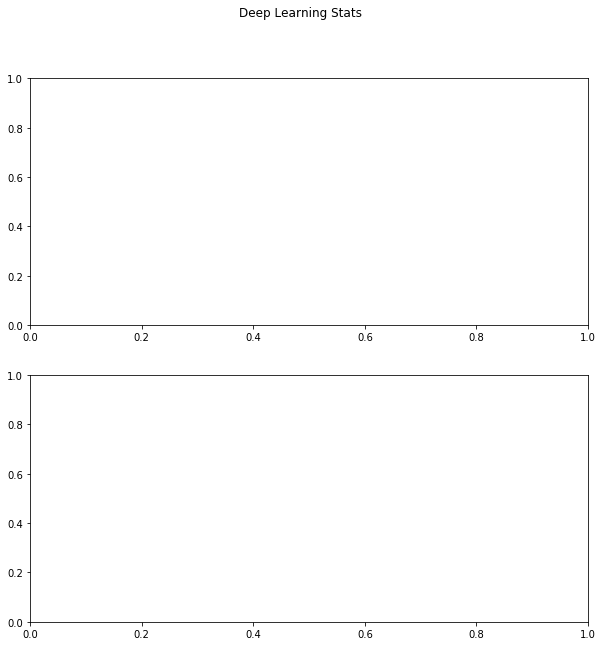

In [236]:
def plot_keras_history(model):
    history = model.history.history
    e = range(1, NB_START_EPOCHS + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Deep Learning Stats')
    ax1.plot(e, history['loss'], 'bo', label = 'Train Loss')
    ax1.plot(e, history['val_loss'], 'b', label = 'Vaidation Loss')
    ax2.plot(e, history['accuracy'], 'ro', label = 'Train Accuracy')
    ax2.plot(e, history['val_accuracy'], 'r', label = 'Vaidation Accuracy')

    ax1.legend()
    ax2.legend()
    plt.show()
    
plot_keras_history(base_model_fit)

In [239]:
base_model_fit.history.history

{}

## Base Model Analysis
This is overfitting somewhat aggressively, I am going to add some dropouts.

In [98]:
dropout_model = models.Sequential()
dropout_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
dropout_model.add(layers.Dropout(0.5))
dropout_model.add(layers.Dense(64, activation='relu'))
dropout_model.add(layers.Dropout(0.5))
dropout_model.add(layers.Dense(3, activation='softmax'))
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [232]:
dropout_model_fit = compile_fit_model(base_model)
#evaluate_model(dropout_model_fit)

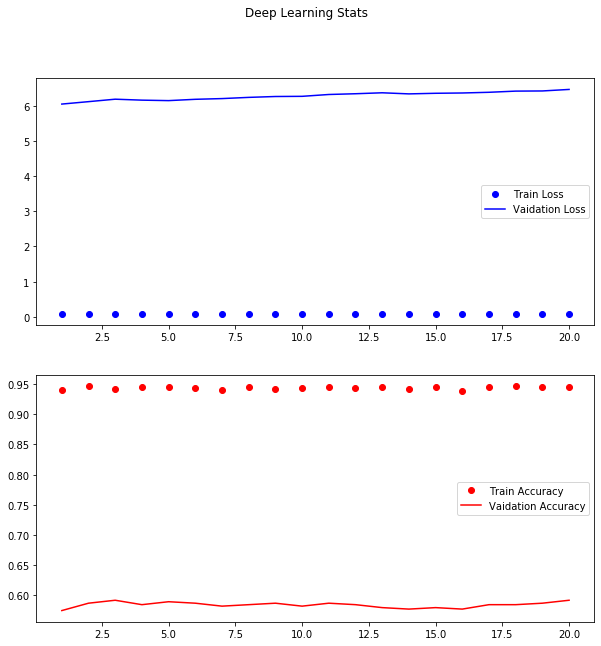

In [234]:
plot_keras_history(dropout_model_fit)

In [233]:
dropout_model_fit.history.history

{'loss': [0.07724320888519287,
  0.0758051797747612,
  0.07582337409257889,
  0.07628101855516434,
  0.07599562406539917,
  0.07582660019397736,
  0.07584892213344574,
  0.07583415508270264,
  0.07573698461055756,
  0.0757487490773201,
  0.07583630084991455,
  0.07627638429403305,
  0.0758621022105217,
  0.07712145894765854,
  0.07578218728303909,
  0.07594409584999084,
  0.07588101923465729,
  0.07571421563625336,
  0.07589787244796753,
  0.07577472925186157],
 'accuracy': [0.9407608509063721,
  0.94701087474823,
  0.9426630139350891,
  0.945380449295044,
  0.945652186870575,
  0.9442934989929199,
  0.939945638179779,
  0.945380449295044,
  0.9426630139350891,
  0.9442934989929199,
  0.9451087117195129,
  0.9442934989929199,
  0.945380449295044,
  0.9413043260574341,
  0.945380449295044,
  0.938043475151062,
  0.945380449295044,
  0.946195662021637,
  0.9451087117195129,
  0.945380449295044],
 'val_loss': [6.046308994293213,
  6.115255832672119,
  6.185051441192627,
  6.15794420242309

## Dropout Model Analysis
This definately helped, but its still going too fast. I am going to add a regularization penalty and see if that helps.

In [204]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,), kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                640064    
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


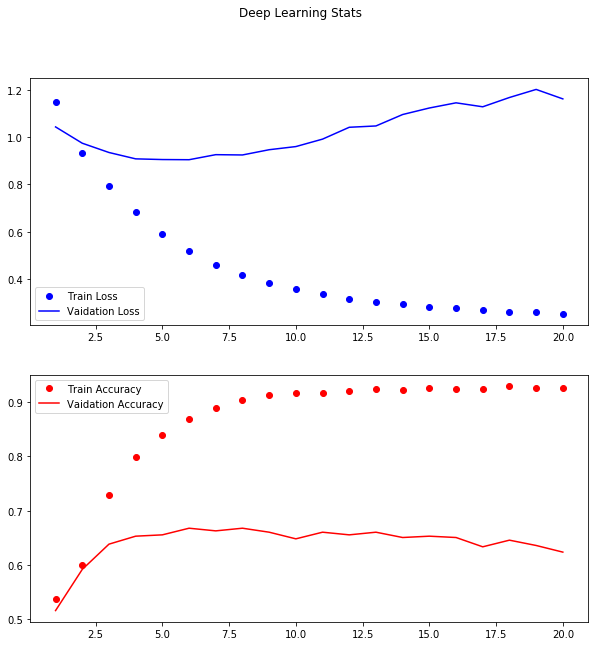

In [205]:
reg_model_fit = compile_fit_model(reg_model)
plot_keras_history(reg_model_fit)

In [220]:
evaluate_model(reg_model)

'Accuracy of 63.78% and loss of 1.10'

In [217]:
type(reg_model) == models.Sequential

True

## Regularization Model Analysis
This is way way better.

# Count Vectorizer and Keras

In [196]:
CV = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=True)

X_train_CV = CV.fit_transform(X_train)
X_test_CV = CV.transform(X_test)

print(type(X_train_CV)) # Sparse Matrix

<class 'scipy.sparse.csr.csr_matrix'>


In [199]:
# Fast and dirty Multinomial Bayes score
mb = MultinomialNB()
mb.fit(X_train_CV, y_train).score(X_test_CV, y_test)

0.6657159155733029